In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # Set up visualizations
plt.rcParams['figure.dpi'] = 180
# plt.rcParams["figure.figsize"] = (10, 6)
sns.set_theme(rc={
    'axes.facecolor': '#FFFFFF',
    'figure.facecolor': '#FFFFFF',
    'font.sans-serif': 'DejaVu Sans',
    'font.family': 'sans-serif'
})
pd.set_option('display.max_rows', 50000000)
pd.set_option('display.width', 1000) 

df = pd.read_csv("assets/offesnse-data/NE/combined/full_route_combos.csv")

# Define the Revised Field Zones
def categorize_field(yardline):
    if 0 <= yardline <= 25:
        return 'Opponent Red Zone'
    elif 26 <= yardline <= 50:
        return 'Midfield'
    elif 51 <= yardline <= 75:
        return 'Own Territory'
    elif 76 <= yardline <= 100:
        return 'Own Deep Zone'
    else:
        return 'Unknown'

# Apply the Revised Categorization
df['field_zone'] = df['yardline_100'].apply(categorize_field)

In [148]:
df.head().T

,0,1,2,3,4
gameId,2022091106,2022091106,2022091106,2022091106,2022091806
playId,59,196,236,633,182
down,1,1,1,1,1
pass_length,short,short,deep,short,short
offenseFormation,SHOTGUN,SHOTGUN,SHOTGUN,SHOTGUN,SHOTGUN
receiverAlignment,2x2,2x2,2x2,2x2,3x1
pass_location,right,left,right,left,right
yardsToGo,10,10,10,10,10
absoluteYardlineNumber,35,77,88,54,30
pff_manZone,Zone,Zone,Man,Zone,Zone


In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

def get_label_rotation(angle, offset):
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation += 180
    else:
        alignment = "left"
    return rotation, alignment

def add_labels(angles, values, labels, offset, ax):
    padding = 10
    for angle, value, label in zip(angles, values, labels):
        rotation, alignment = get_label_rotation(angle, offset)
        ax.text(
            x=angle,
            y=value + padding,
            s=label,
            ha=alignment,
            va="center",
            rotation=rotation,
            rotation_mode="anchor",
            fontsize=9,
            fontweight="bold"
        )

def process_and_plot_curcularbarplot(df, group_cols, value_col, category_label,circularbar_cmap_name, inner_radius=100, ax=None):
    outcomes = df.groupby(group_cols, dropna=True)[value_col].value_counts().unstack().reset_index()
    value_types = list(df[value_col].unique())
    temp_df = (
        outcomes.groupby(group_cols, dropna=True)[value_types].sum().reset_index()
    )
    temp_df["row_sum"] = temp_df.loc[:, value_types].sum(axis=1)
    temp_df[value_types] = temp_df[value_types].apply(lambda x: x / temp_df["row_sum"])
    
    circular_df = temp_df[[category_label, "row_sum", "field_zone"]]
    circular_df = circular_df.sort_values(by=["field_zone", category_label])
    
    VALUES = circular_df["row_sum"].values
    LABELS = circular_df[category_label].values
    GROUP = circular_df["field_zone"].values
    PAD = 3
    ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
    ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
    WIDTH = (2 * np.pi) / len(ANGLES)
    GROUPS_SIZE = [len(i[1]) for i in circular_df.groupby("field_zone")]
    OFFSET = np.pi / 2
    offset = 0
    IDXS = []
    for size in GROUPS_SIZE:
        IDXS += list(range(offset + PAD, offset + size + PAD))
        offset += size + PAD

    if ax is None:
        _, ax = plt.subplots(subplot_kw={"projection": "polar"})
    
    ax.set_theta_offset(OFFSET)
    ax.set_ylim(-100, inner_radius)
    ax.set_frame_on(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    unique_groups = np.unique(GROUP)
    group_names = {
        'A': 'Midfield',
        'B': 'Opponent Red Zone',
        'C': 'Own Deep Zone',
        'D': 'Own Territory'
    }
    palette = sns.color_palette(circularbar_cmap_name, n_colors=len(unique_groups))
    group_colors = {group: palette[i] for i, group in enumerate(unique_groups)}
    COLORS = [group_colors[group] for group in GROUP]
    
    ax.bar(
        ANGLES[IDXS],
        VALUES,
        width=WIDTH,
        color=COLORS,
        edgecolor="black",
        linewidth=1
    )
    
    add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)
    
    offset = 0
    for group, size in zip(["","","",""], GROUPS_SIZE):
        x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
        ax.plot(x1, [-5] * 50, color="#333333")
        ax.text(
            np.mean(x1),
            -20,
            group,
            color="#333333",
            fontsize=14,
            fontweight="bold",
            ha="center",
            va="center"
        )
        x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
        ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
        ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
        offset += size + PAD
    
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=group_colors[group], edgecolor='white', label=group_names.get(group, group)) for group in unique_groups]
    legend = ax.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.01), ncol=len(unique_groups))
    legend.set_frame_on(False)

def process_and_plot_heatmap(fig_width, fig_height, df, group_cols, value_col, category_label, heatmap_cmap_name, ax=None):
    outcomes = df.groupby(group_cols, dropna=True)[value_col].value_counts().unstack().reset_index()
    value_types = list(df[value_col].unique())
    temp_df = (
        outcomes.groupby(group_cols, dropna=True)[value_types].sum().reset_index()
    )
    temp_df["row_sum"] = temp_df.loc[:, value_types].sum(axis=1)
    temp_df[value_types] = temp_df[value_types].apply(lambda x: x / temp_df["row_sum"])
    
    melted_df = temp_df.melt(
        id_vars=group_cols[0],
        value_vars=value_types,
        var_name="field_zone",
        value_name="proportion"
    )
    categories = list(melted_df[group_cols[0]].unique())
    sorted_categories = sorted(categories, key=str.lower)
    melted_df[group_cols[0]] = pd.Categorical(
        melted_df[group_cols[0]],
        categories=sorted_categories,
        ordered=True
    )
    melted_df = melted_df.sort_values(group_cols[0], ascending=False)

    
    y_spacing_factor = 0.5
    x_spacing_factor = 0.5
    y_mapping = {category: i * y_spacing_factor for i, category in enumerate(sorted_categories)}
    melted_df['y_pos'] = melted_df[group_cols[0]].map(y_mapping)
    sorted_x_categories = sorted(melted_df["field_zone"].unique(), key=str.lower)
    x_mapping = {category: i * x_spacing_factor for i, category in enumerate(sorted_x_categories)}
    melted_df['x_pos'] = melted_df["field_zone"].map(x_mapping)
    
    cmap = plt.get_cmap(heatmap_cmap_name)
    if ax is None:
        _, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    for value_type in value_types:
        d = melted_df[melted_df["field_zone"] == value_type]
        y = d['y_pos']
        x = d['x_pos']
        color = cmap(d["proportion"])
        ax.scatter(x, y, color=color, s=250, edgecolor="k")
    
    ax.set_frame_on(False)
    ax.grid(which='major', color='#CCCCCC', linestyle='--',alpha=0.8)
    ax.grid(which='minor', color='#CCCCCC', linestyle=':',alpha=0.8)
    ax.set_axisbelow(True)
    ax.set_xticks([x_mapping[cat] for cat in sorted_x_categories])
    ax.set_xticklabels(sorted_x_categories, ha='right')
    ax.set_yticks([y_mapping[cat] for cat in sorted_categories])
    ax.set_yticklabels(sorted_categories)
    ax.set_ylim(-y_spacing_factor, (len(sorted_categories) - 1) * y_spacing_factor + y_spacing_factor / 2)
    ax.set_xlim(-x_spacing_factor, (len(sorted_x_categories) - 1) * x_spacing_factor + x_spacing_factor / 2)
    ax.tick_params(axis='both', which='both', length=0, colors="0.3")
    ax.set_xlabel(value_col, loc="right")

def plot_combined(fig_width, fig_height, df,group_cols,value_col,category_label,heatmap_cmap_name="BuGn",circularbar_cmap_name="Set3",inner_radius=100):
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 3, width_ratios=[.1, 0.5, 0.1]) 
    ax_heatmap = fig.add_subplot(gs[0])
    process_and_plot_heatmap(
        fig_width=fig_width,
        fig_height=fig_height,
        df=df,
        group_cols=group_cols,
        value_col=value_col,
        category_label=category_label,
        heatmap_cmap_name=heatmap_cmap_name,
        ax=ax_heatmap
    )

    ax_circular = fig.add_subplot(gs[1], projection='polar')
    process_and_plot_curcularbarplot(
        df=df,
        group_cols=group_cols,
        value_col=value_col,
        category_label=category_label,
        ax=ax_circular,
        circularbar_cmap_name=circularbar_cmap_name,
        inner_radius=inner_radius
    )

    plt.tight_layout()
    plt.show()




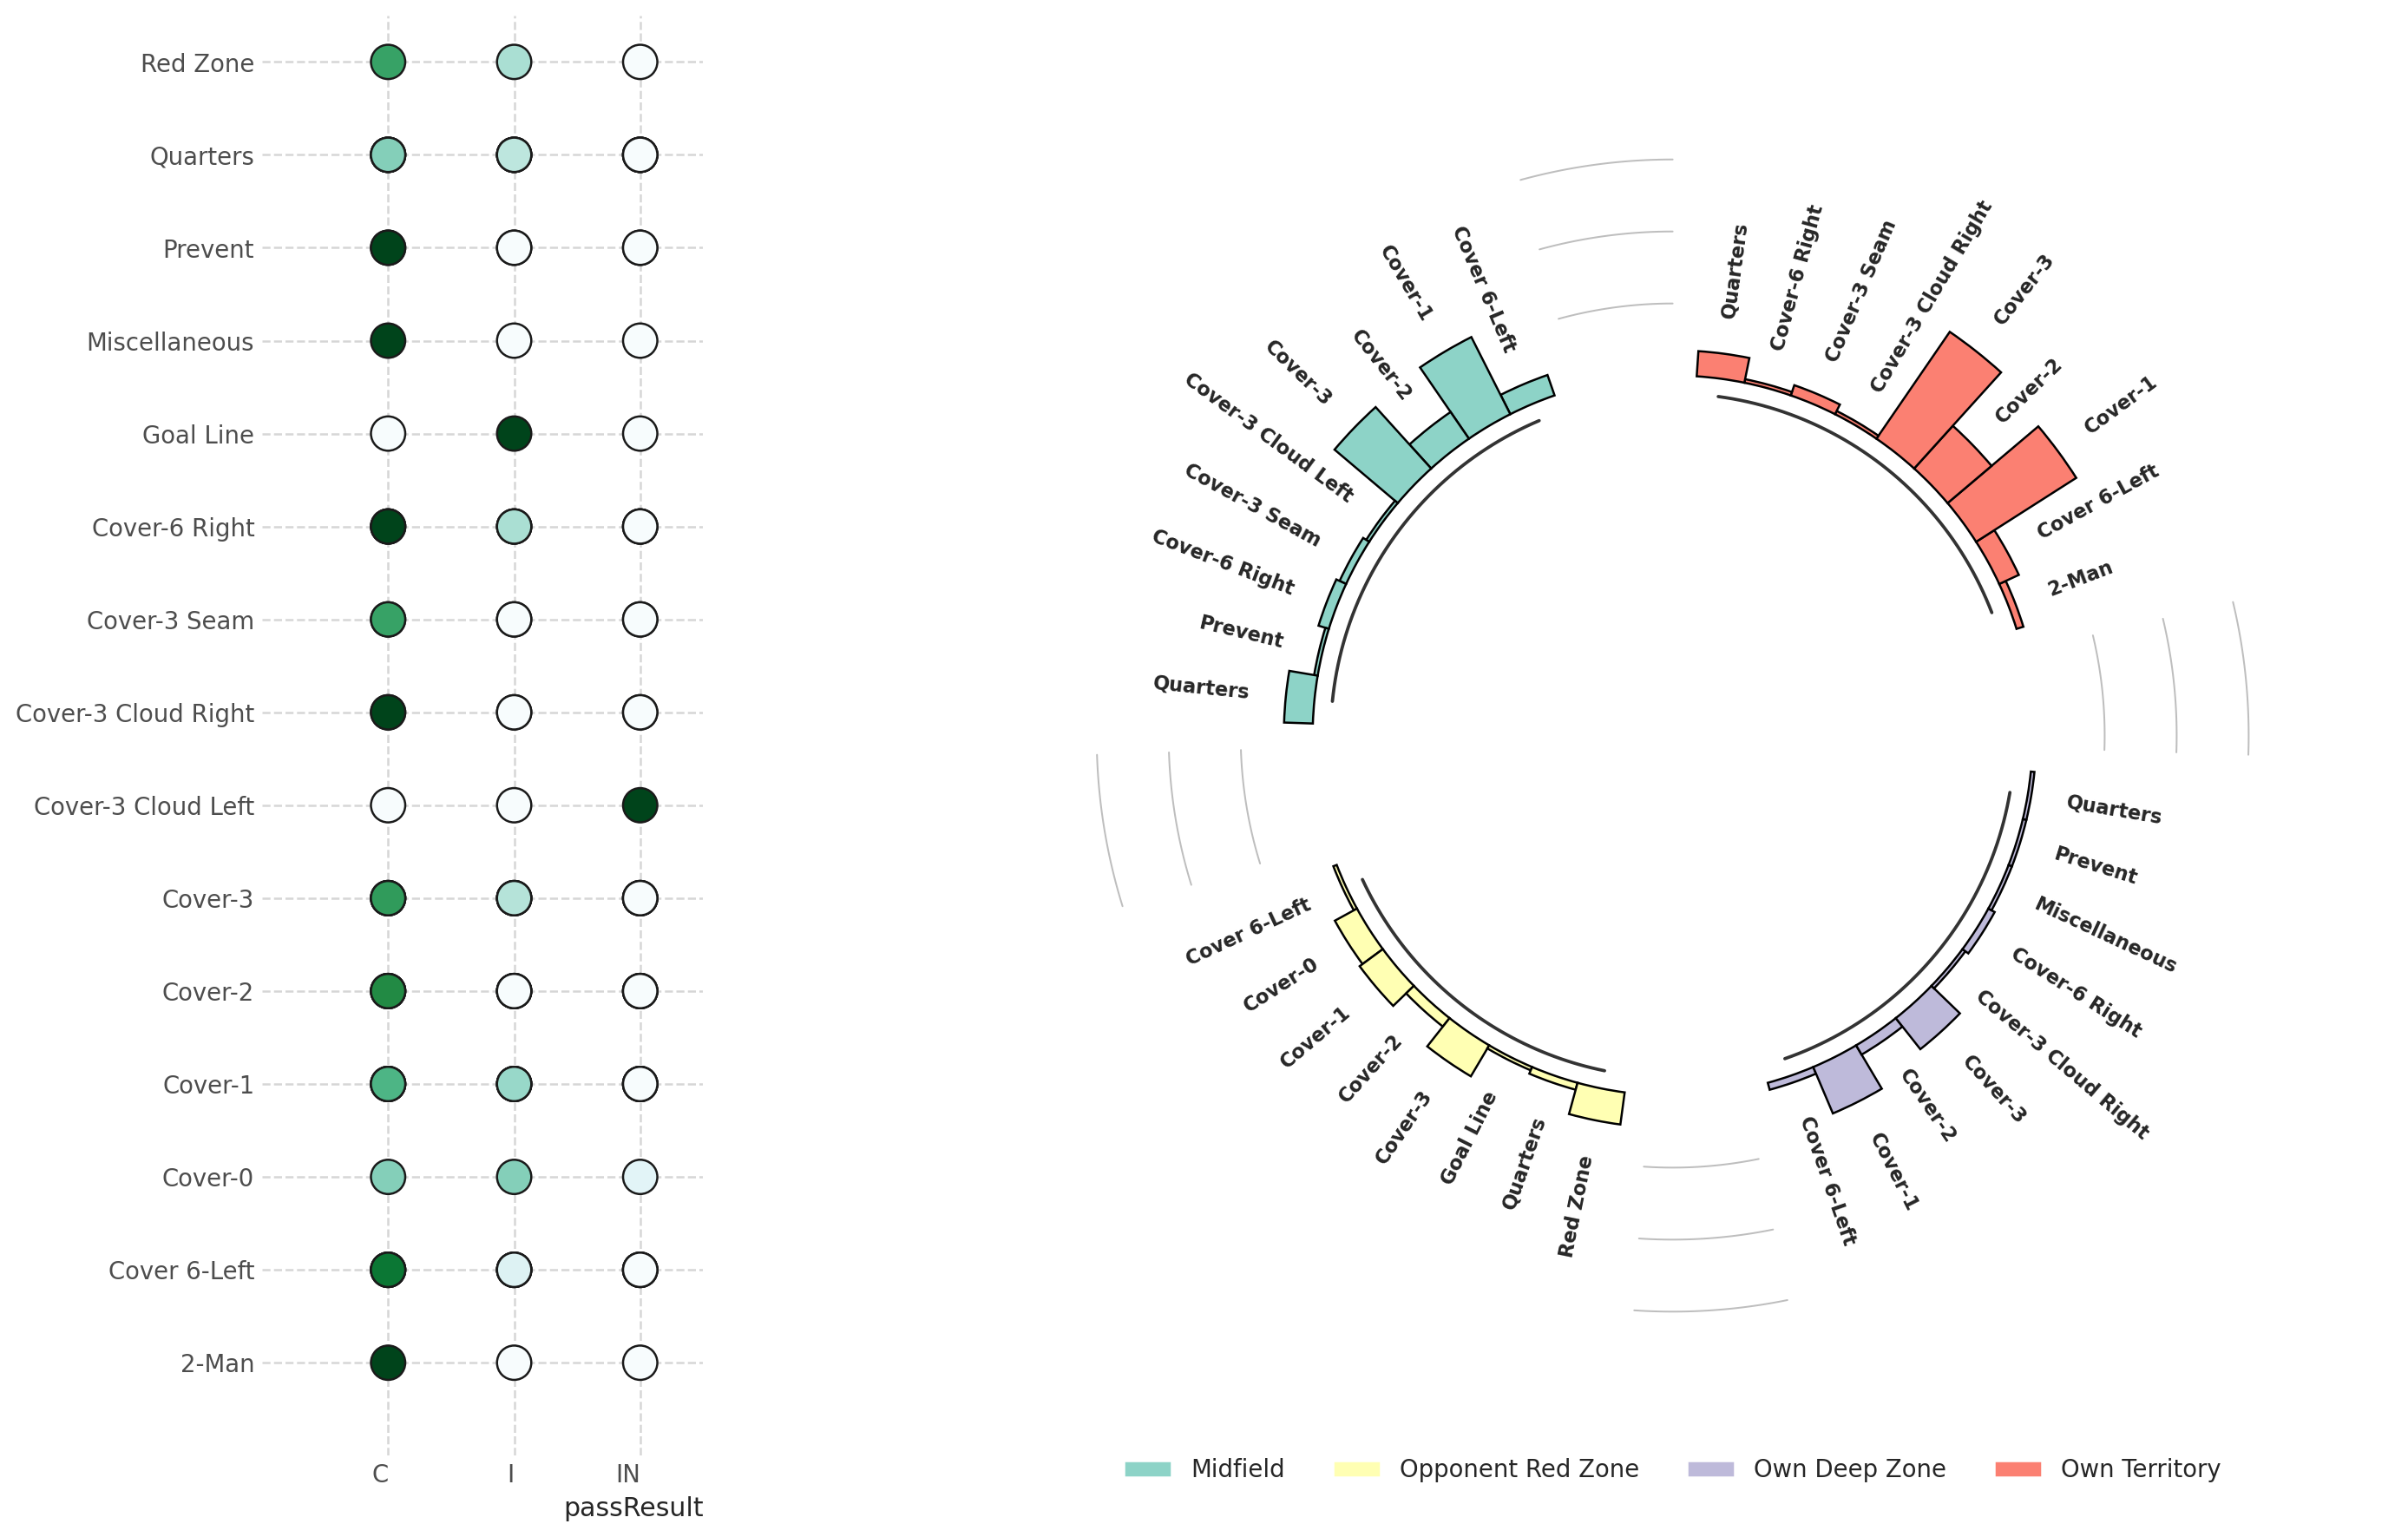

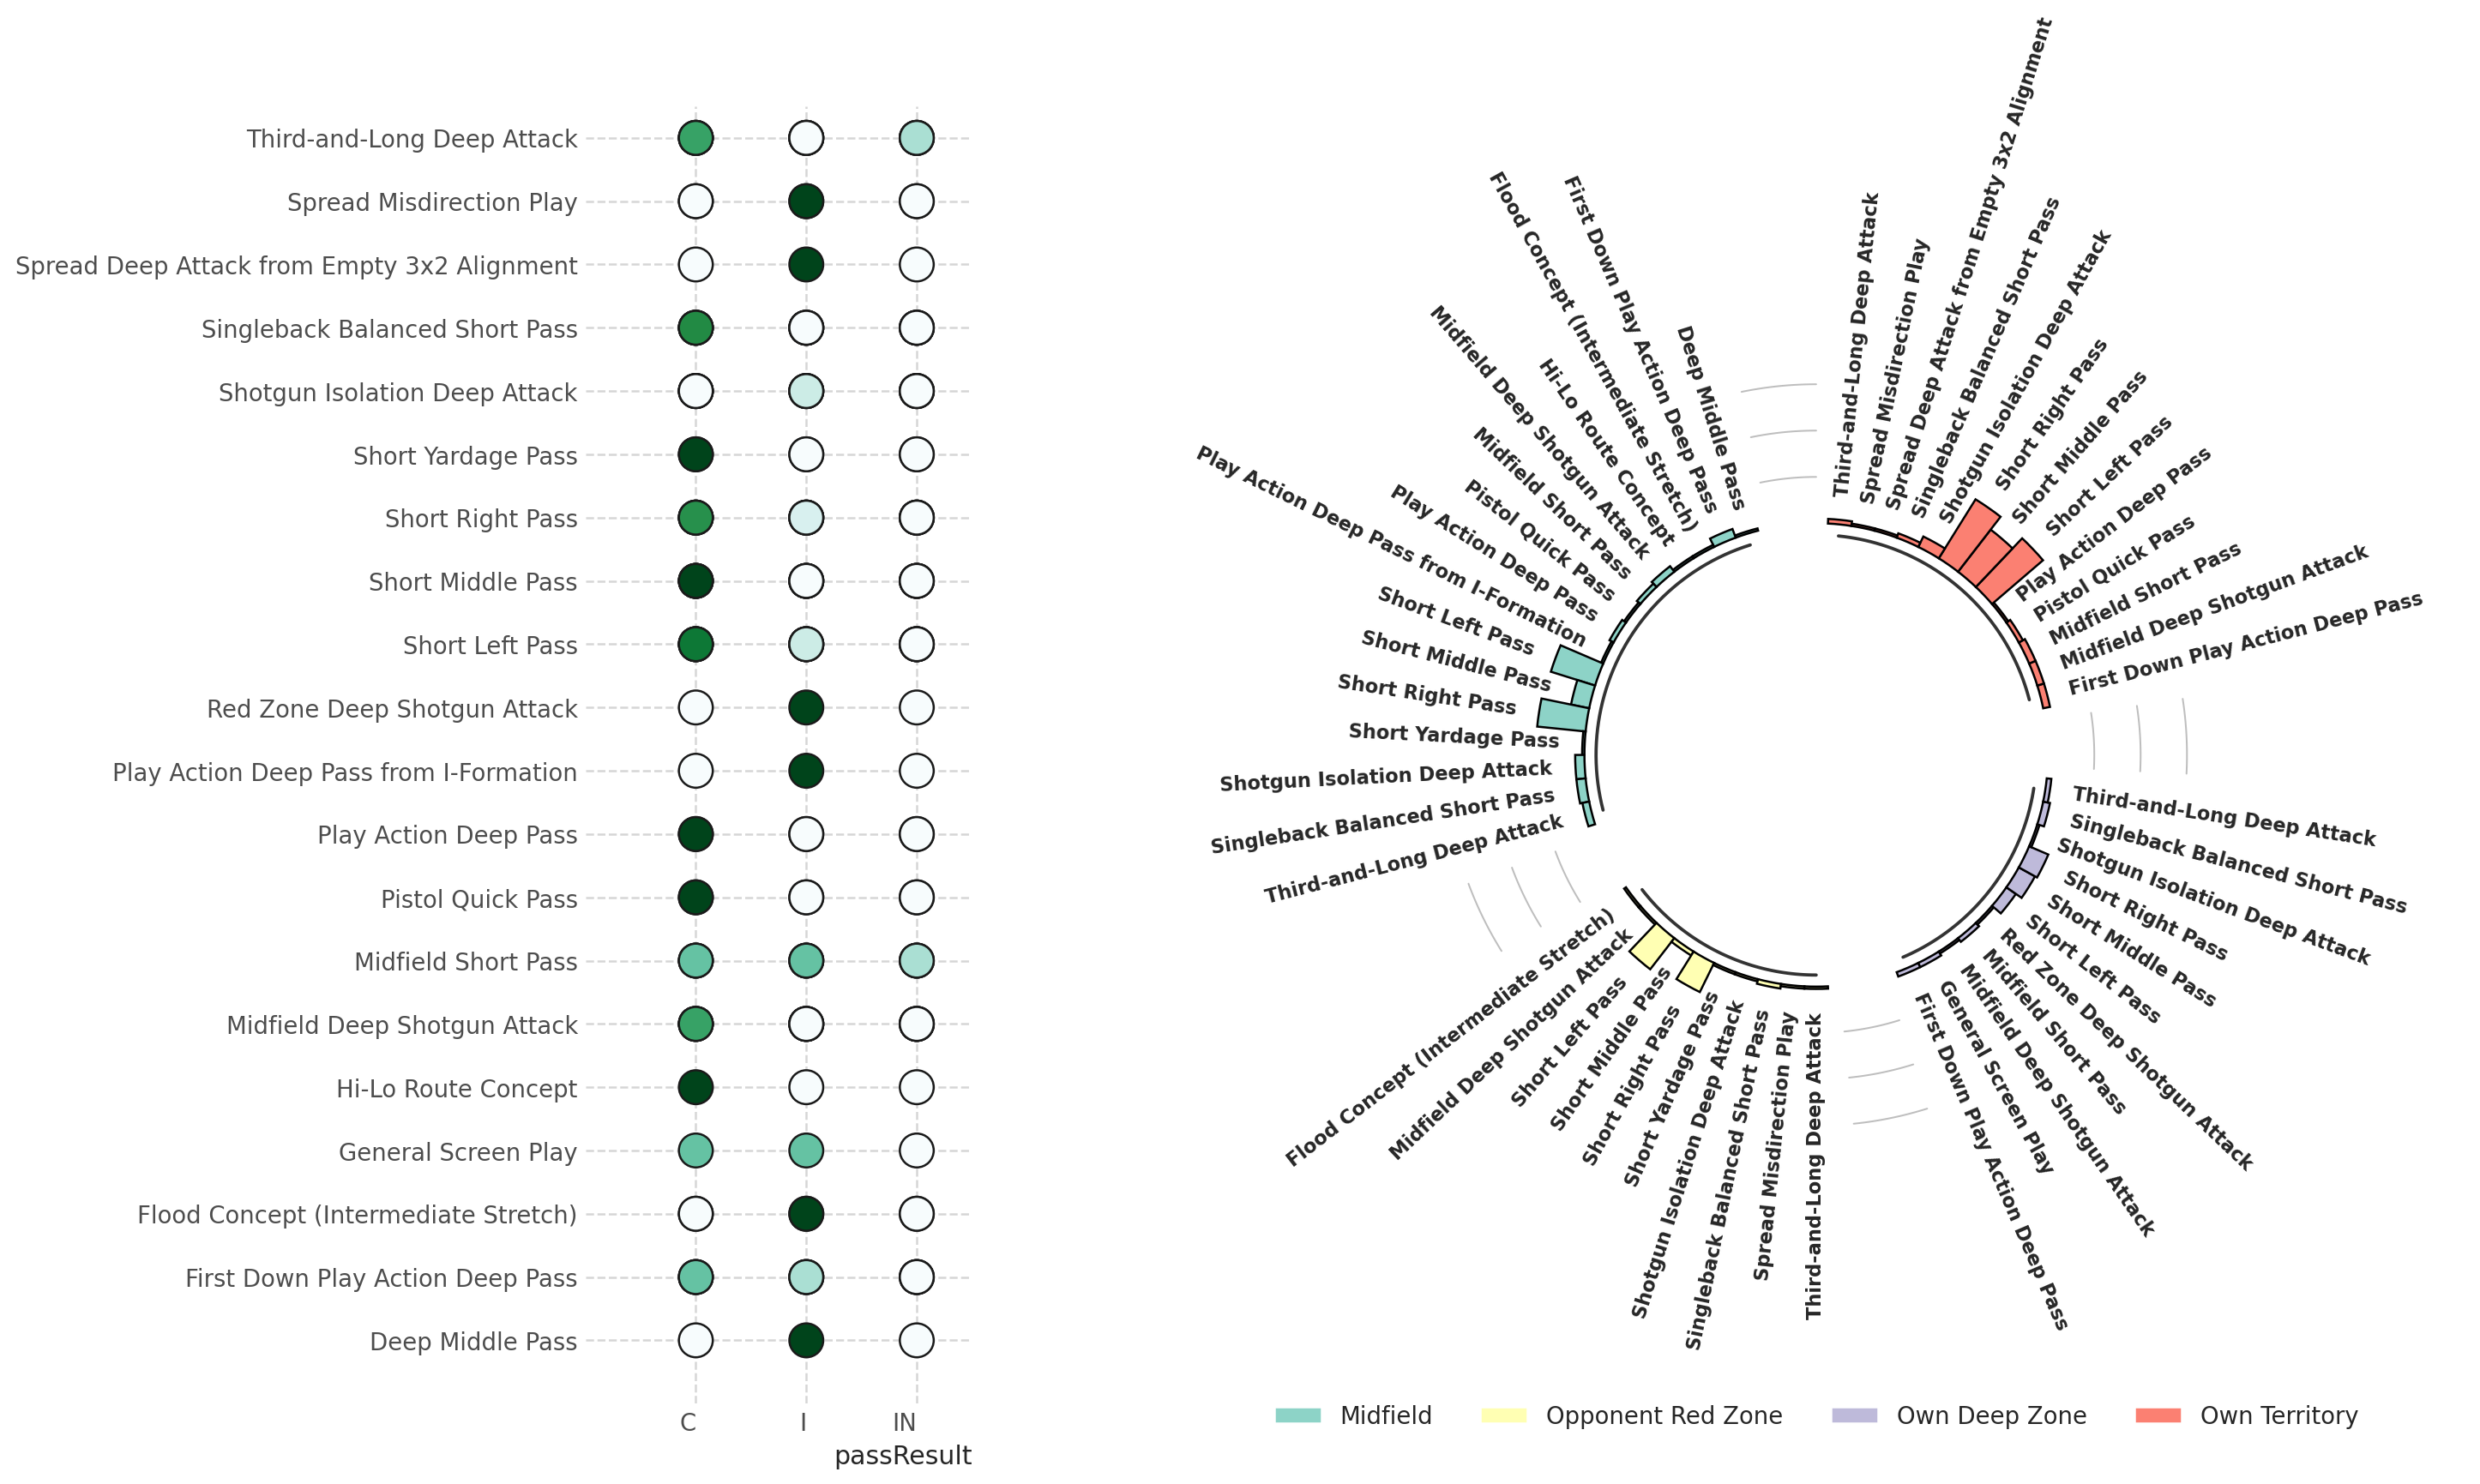

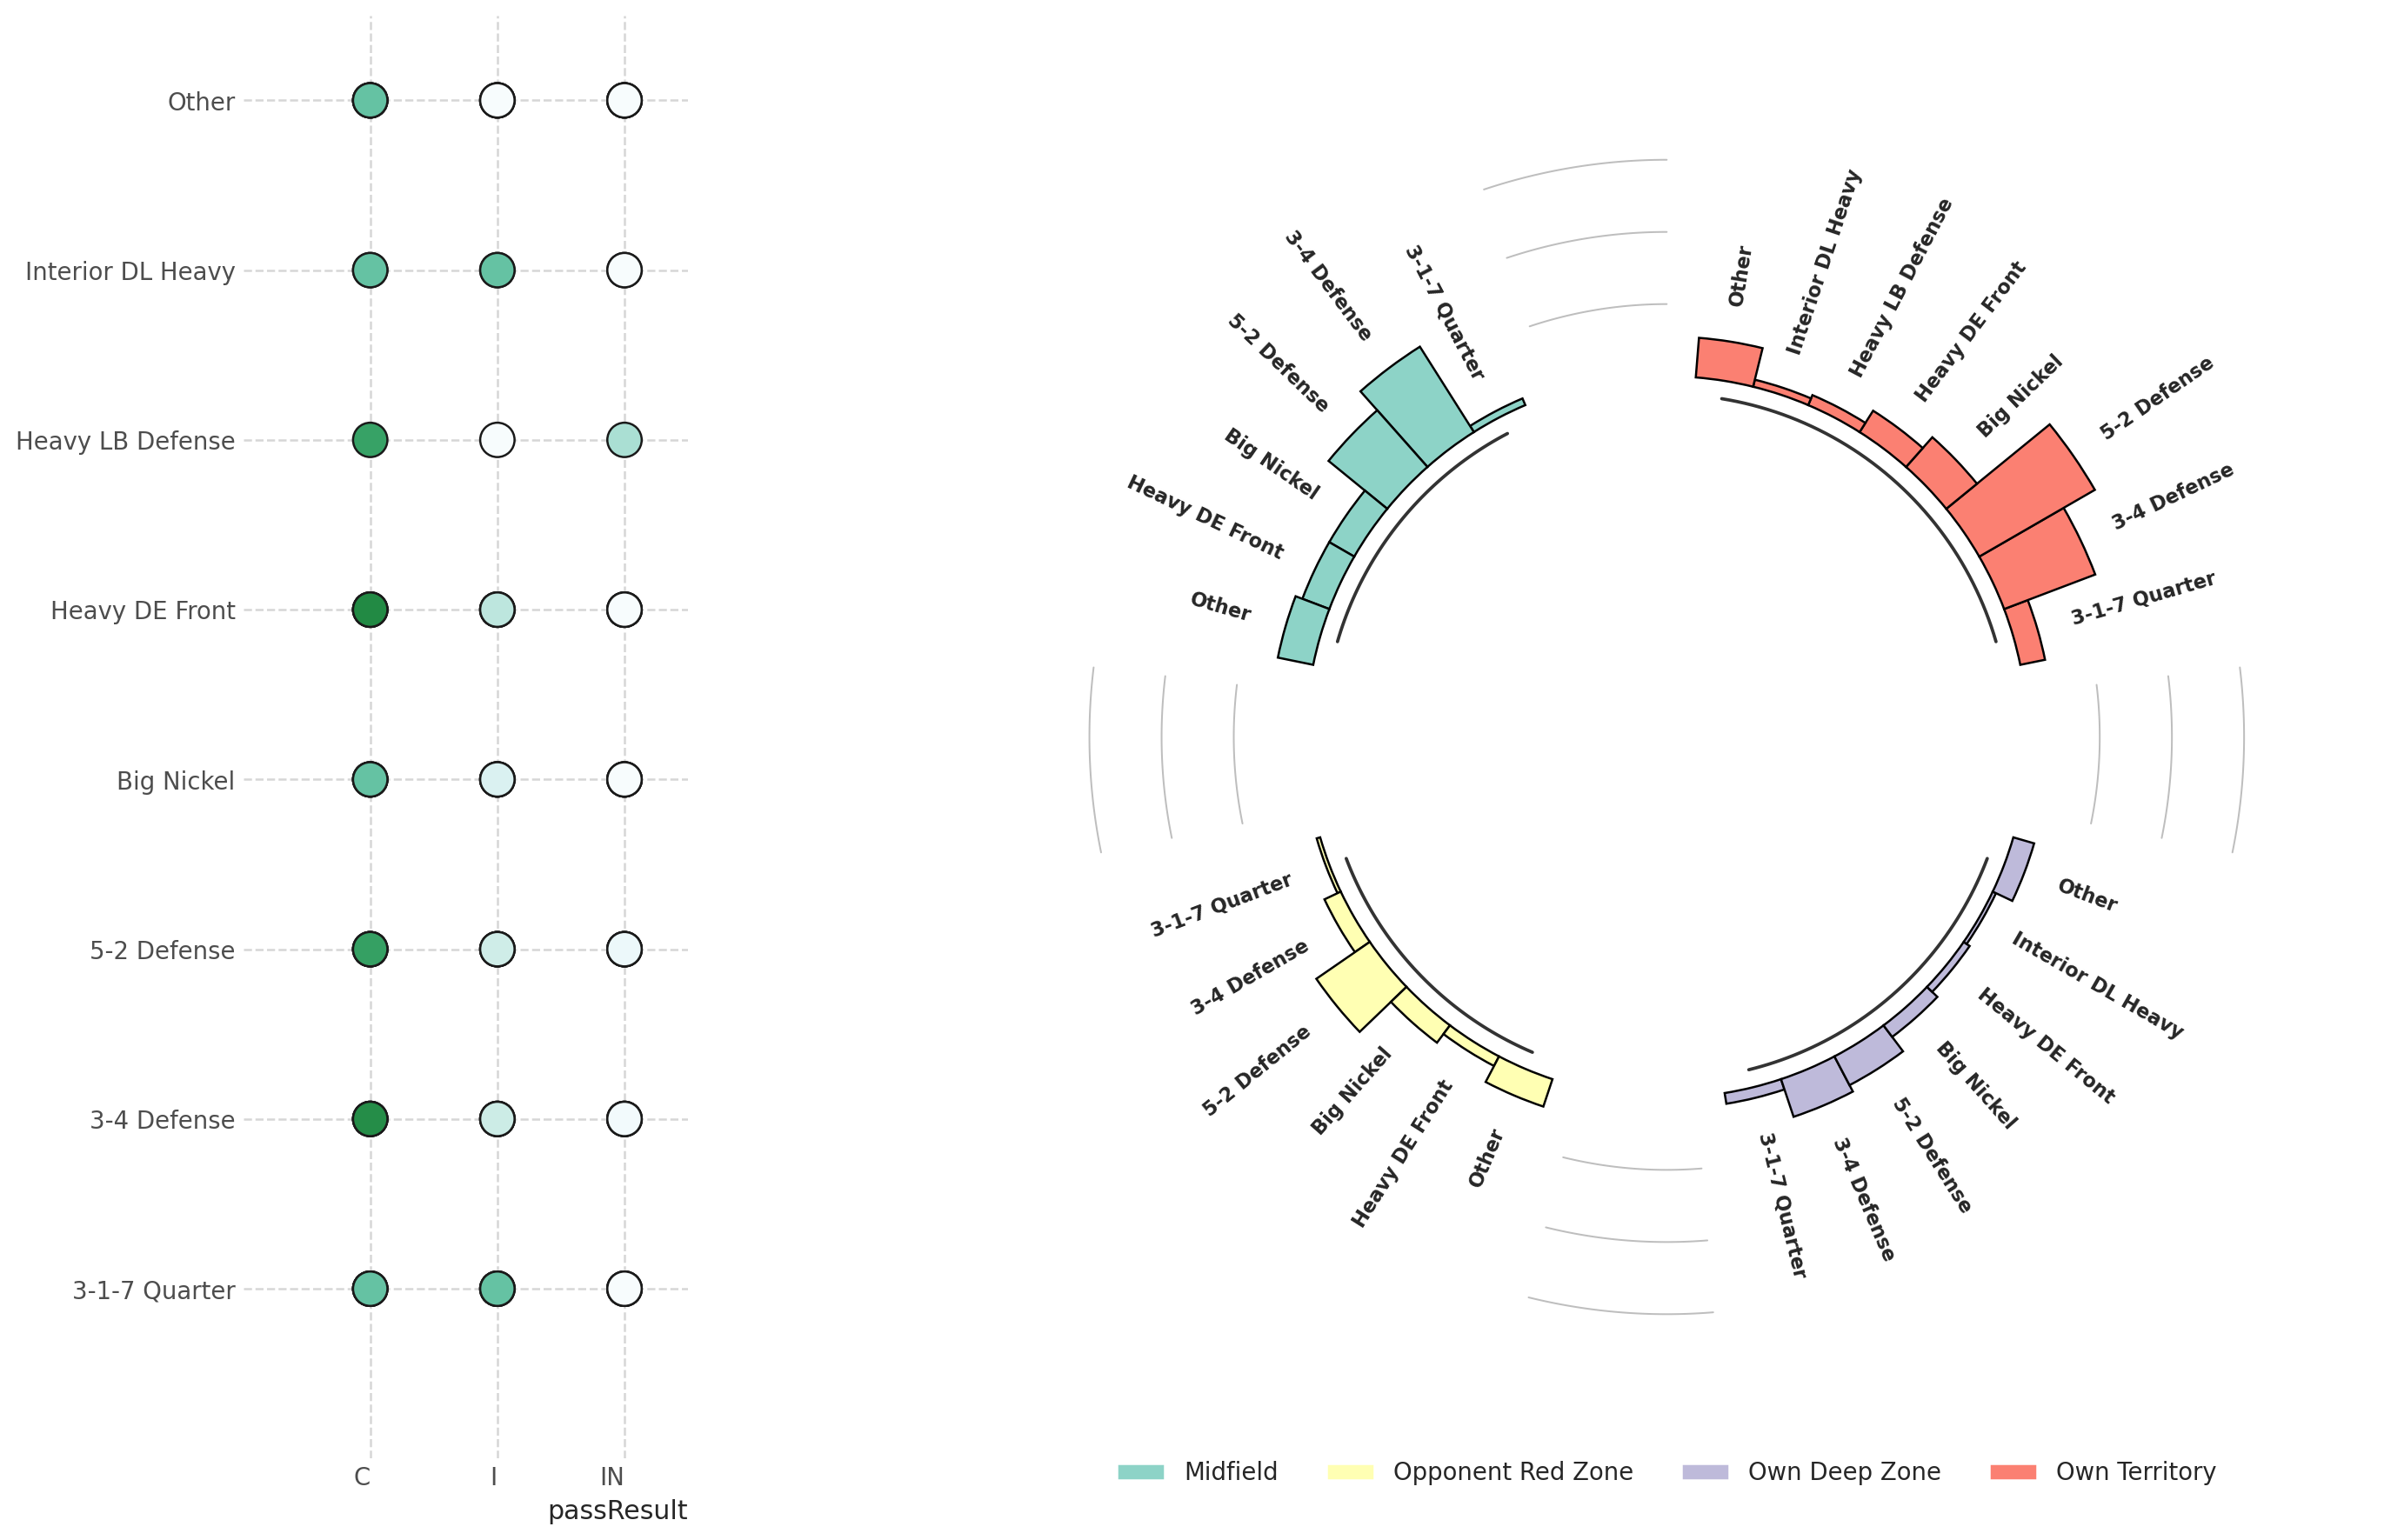

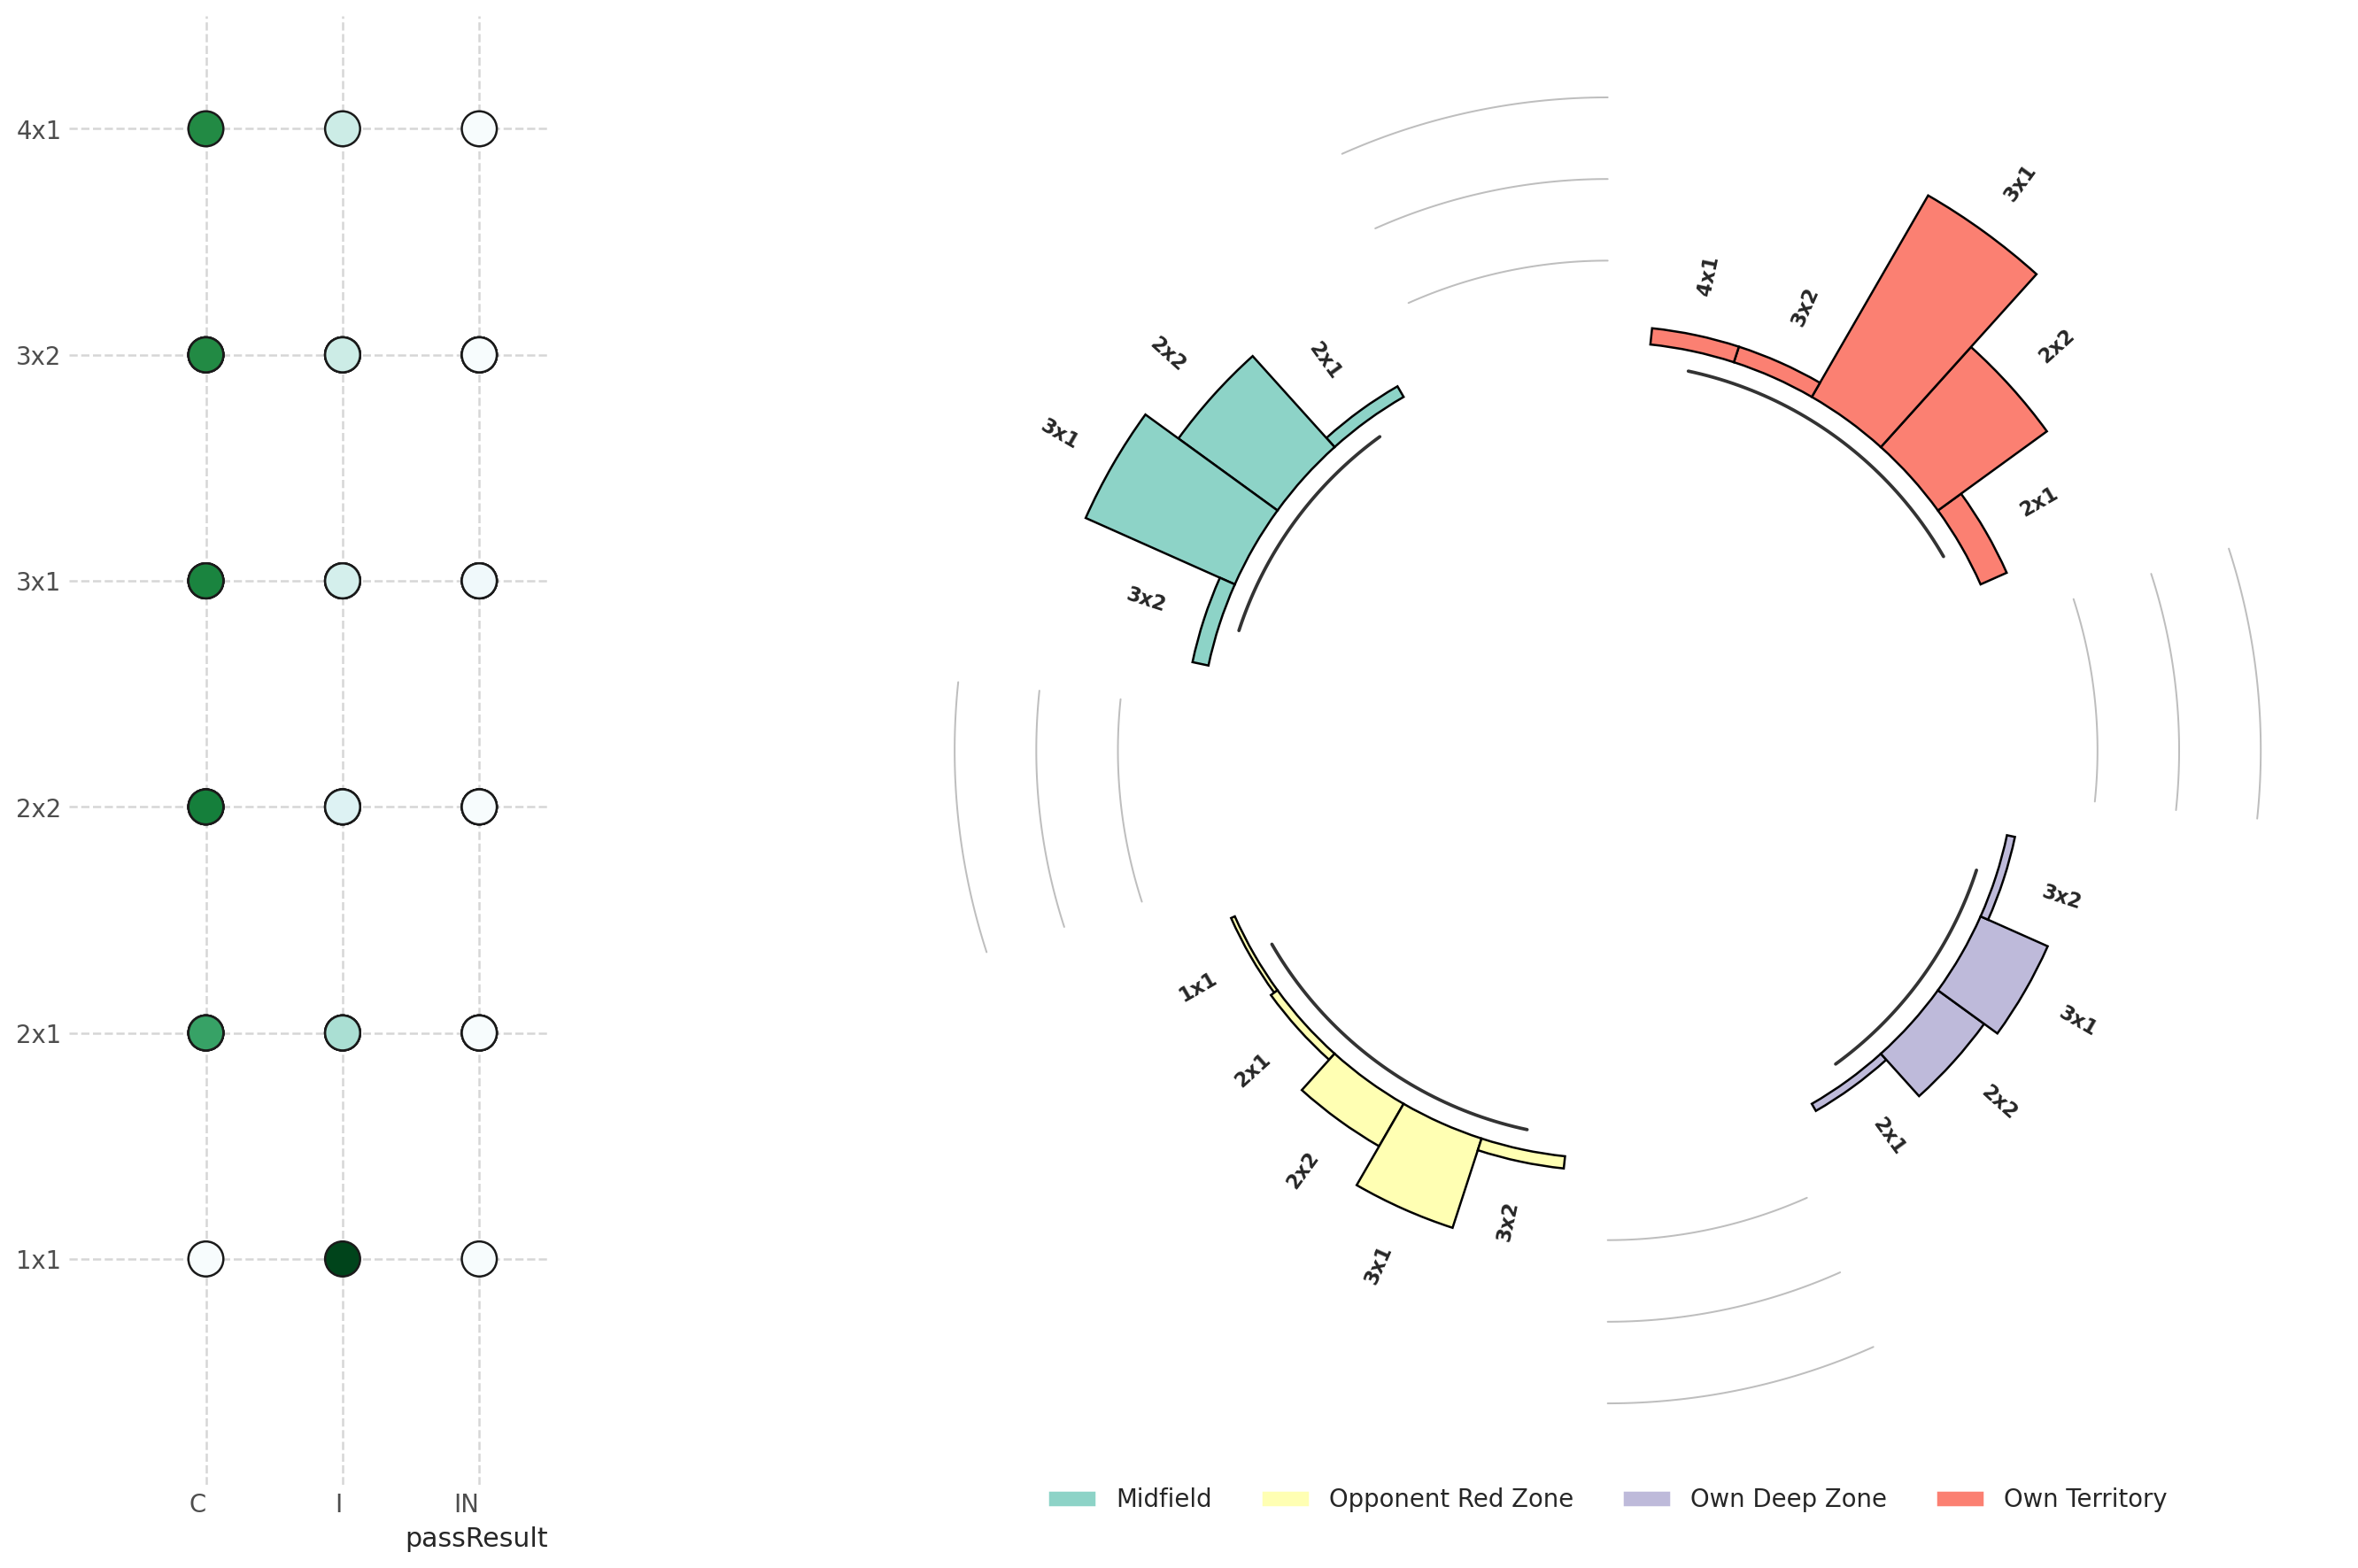

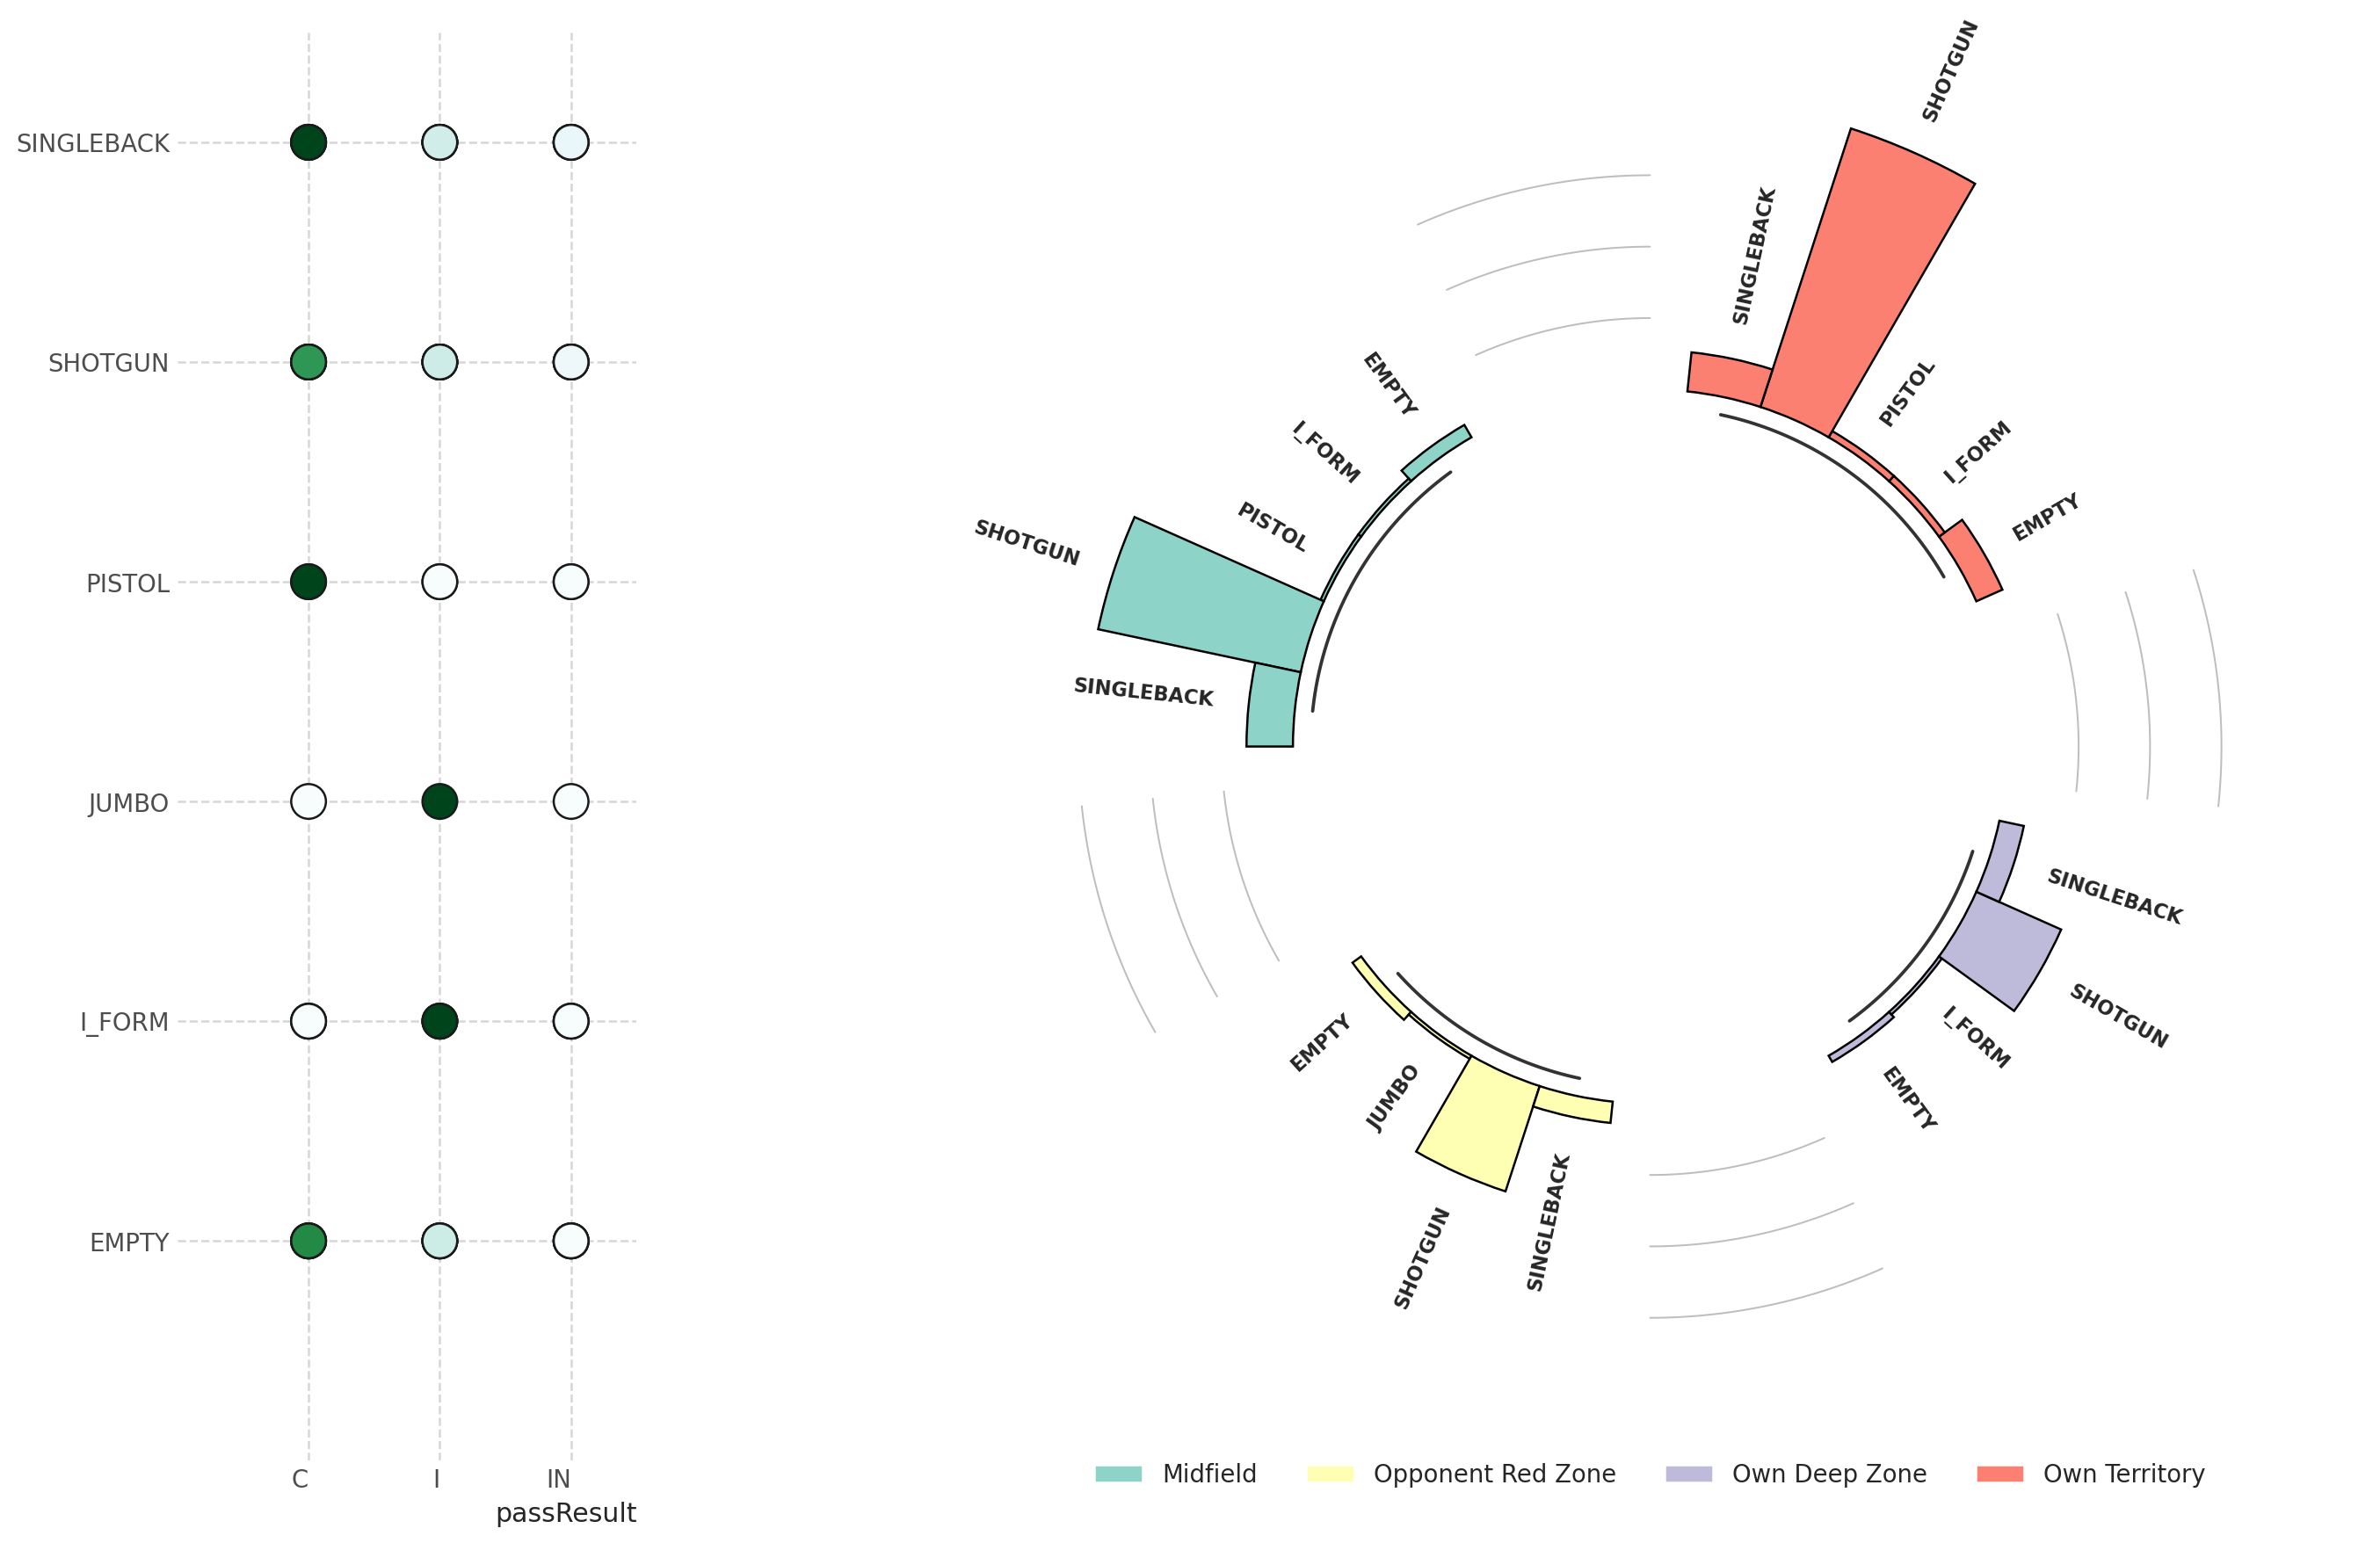

In [151]:
# Assuming df is your DataFrame
plot_combined(
    fig_width=3,
    fig_height=8,
    df=df,
    group_cols=["pff_passCoverage", "field_zone"],
    value_col="passResult",
    category_label="pff_passCoverage"
)

# For plot_combined
plot_combined(
    fig_width=4,
    fig_height=10,
    df=df,
    group_cols=["strategy", "field_zone"],
    value_col="passResult",
    category_label="strategy",
    inner_radius=180
)

# For defenseFormation
plot_combined(
    fig_width=3,
    fig_height=8,
    df=df,
    group_cols=["defenseFormation", "field_zone"],
    value_col="passResult",
    category_label="defenseFormation"
)

plot_combined(
    fig_width=0.5,
    fig_height=0.5,
    df=df,
    group_cols=["receiverAlignment", "field_zone"],
    value_col="passResult",
    category_label="receiverAlignment",
   inner_radius=80
)

plot_combined(
    fig_width=0.5,
    fig_height=0.5,
    df=df,
    group_cols=["offenseFormation", "field_zone"],
    value_col="passResult",
    category_label="offenseFormation"
)

